# Deep Learning Mini-Challenge 2: Image Captioning

**Task description:** The aim of this minichallenge is to train an image captioning model. After the training, the model should be able to receive an image and generate a single sentence describing the captured scene. This work is strongly inspired by the paper from Vinyals: *Show and Tell: A Neural Image Caption Generator* (https://arxiv.org/pdf/1411.4555.pdf).

**Description of the dataset:** The Flickr8k data set is used for training the models. It consists of 8091 different images with varying resolutions. The images were collected from six different Flickr groups and were manually selected to include a range of scenes and situations. In addition, 5 captions are included in the dataset for each image which results in a total of 40455 captions. 

In [1]:
import os
import pickle
import wandb
import random
import itertools
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset

from sklearn.model_selection import train_test_split
from torchtext.data.utils import get_tokenizer
from torch.utils.data import DataLoader
import torchtext
from tqdm import tqdm

import torchvision
import torchvision.models as models
from torch.nn.utils.rnn import pad_packed_sequence

from nltk.translate.bleu_score import sentence_bleu

import warnings
warnings.filterwarnings('ignore')

print("torch:", torch.__version__)
print("torchtext:", torchtext.__version__)
print("torchvision:", torchvision.__version__)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

torch: 1.8.1+cpu
torchtext: 0.9.1
torchvision: 0.9.1+cpu
device: cpu


## Import data

In [2]:
def read_labels(label_path, skip_header=True):
    '''
    Reads the labels and caption text from the captions.txt file in the specified path
    '''
    with open(label_path + "captions.txt") as f:
        if skip_header:
            next(f)
        lines = f.readlines()
        lines = [line.replace("\n", "") for line in lines]
        lines = [line.split(".jpg,") for line in lines]
        filenames = [line[0] + ".jpg" for line in lines]
        text = [line[1] for line in lines]
        return(pd.DataFrame([filenames, text], index=(["filename", "text"])).T)


image_path = "../../data/Flickr8k/Images/"
label_path = "../../data/Flickr8k/"


df_caption = read_labels(label_path)
df_caption.head()

,filename,text
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


## Explorative data analysis

### Visualization of Images with their corresponding captions.

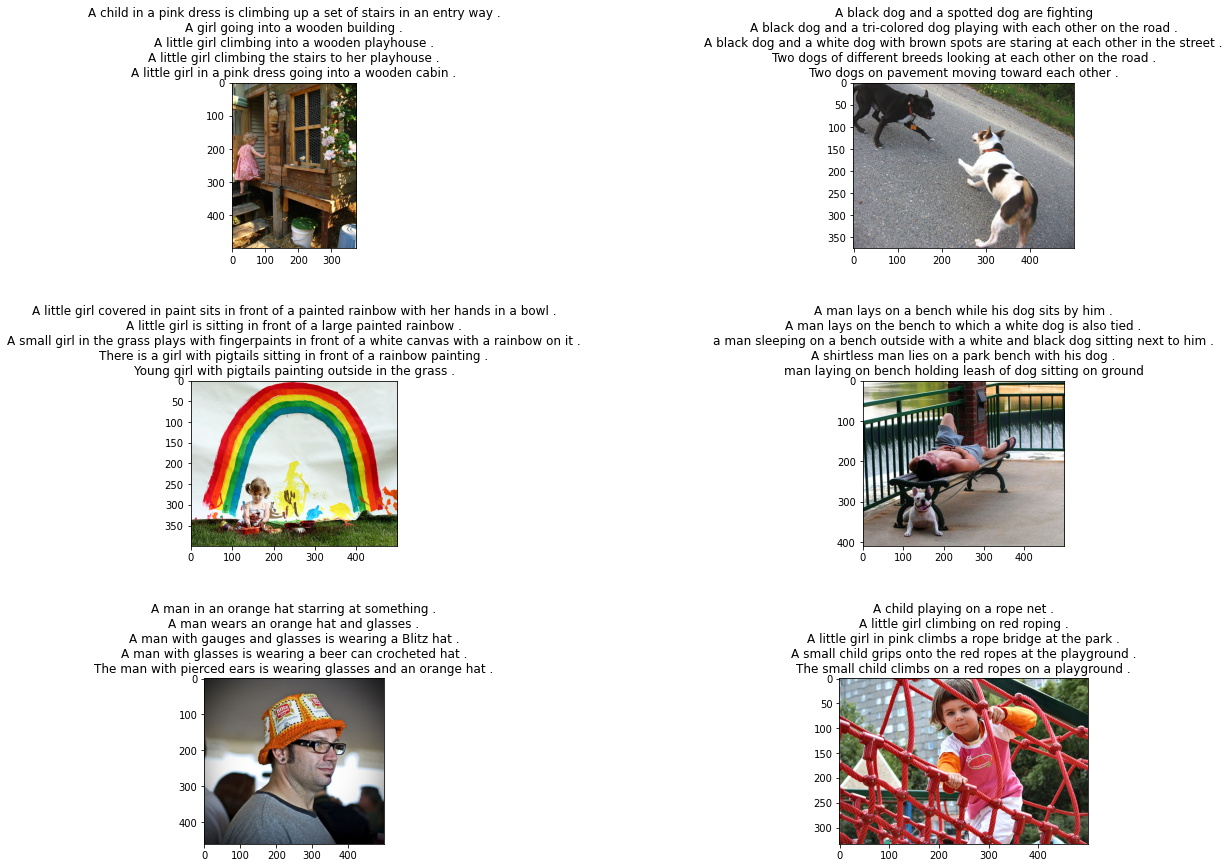

In [3]:
def show_sample_imeages(df, n=3, m=2):
    '''
    Visualises a number of images with the corresponding captions
    '''
    fig, axes = plt.subplots(n, m, figsize=(22,14))
    unique_files = df_caption.filename.unique()

    for i in range(n*m):
        filename = unique_files[i]
        caption = "\n".join(list(df.loc[df["filename"]==unique_files[i]]["text"]))
        img = mpimg.imread(image_path + filename)
        axes[i//m, i%m].imshow(img)
        axes[i//m, i%m].set_title(caption)
    plt.subplots_adjust(hspace = 0.8)
    plt.show()


show_sample_imeages(df_caption)

**Description:** We see the first six images from the dataset with their corresponding captions. The images have varying resolutions. The scenes contain people or animals performing a simple action. The captions in the dataset seem relatively clean at first glance. However, there are case-sensitive differences for individual words. In general, some editing will be necessary for the images and the captions, but the effort will probably not be too high.

### Average caption lengths

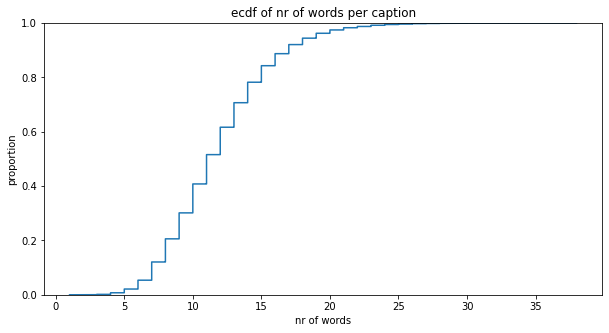

0.50    11.0
0.60    12.0
0.70    13.0
0.80    15.0
0.90    17.0
0.95    19.0
1.00    38.0
Name: text, dtype: float64

In [4]:
plt.figure(figsize=(10,5))
sns.ecdfplot(df_caption.text.apply(str.split).apply(len))
plt.title("ecdf of nr of words per caption")
plt.xlabel("nr of words")
plt.ylabel("proportion")
plt.show()

(df_caption.text.apply(str.split).apply(len)).quantile([.5,.6,.7,.8,.9,.95,1])

**Description:** The captions in the data set are a maximum of 38 words long. A word length of 19 would already be sufficient for over 95 percent of the captions.

### Image resolutions

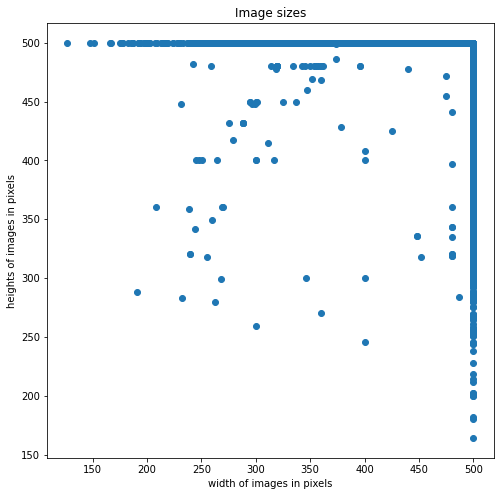

In [5]:
def plot_image_sizes(df):
    '''
    Visualizes the height and width of the images in nr of pixels.
    '''
    # read image sizes
    widths, heights = [], []
    for i in range(len(df)):
        filename = df.iloc[i]
        img = mpimg.imread(image_path + filename)
        width, heigth, chanels = np.shape(img)
        widths.append(width)
        heights.append(heigth)

    #create plot
    plt.figure(figsize=(8,8))
    plt.scatter(widths, heights)
    plt.title("Image sizes")
    plt.xlabel("width of images in pixels")
    plt.ylabel("heights of images in pixels")
    plt.show()

unique_filenames = df_caption["filename"].drop_duplicates()
plot_image_sizes(unique_filenames)

**Descriptions:** The visualization shows the resolution of the images with their number of pixels in height and width. As already recognized in the visualized samples, the images vary in their resolution. However, a clear maximum boundary of 500 pixels is noticeable in the height and width over all images. For the CNN, it is necessary in our case that all images have the same resolution. For this reason, the images must be processed in a next step.

## Preprocessing 

### Preprocessing Images

This section handles the preprocessing of the images, which includes the following transformations: 
- `ToPILImage` Transformes the input images to a PIL image which provides the python interpreter with editing capabilities using the **P**ython **I**maging **L**ibrary.
- `CenterCrop` Crops the images from the center, resulting in a fixed image resolution.  In our case since the maximal resolution is 500 x 500 pixels, the images with less pixels recieve a padding of zeros to fill the gap.
- `Resize` Images to a resolution of 244 x 244 pixels which is the minimal input size for the Resnet18. Because we center cropped all images to the same size before, a distortion of the images is avoided.
- `ToTensor` Transforms the numpy format to a tensor.
- `Normalize` Normalizes the rgb channels of the dataset samples with the average values of the rgb channels.

In [6]:
from torchvision.transforms import Compose, CenterCrop, Resize, ToTensor, ToPILImage, Normalize

image_transform = Compose([
    ToPILImage(),
    CenterCrop((500, 500)),  # padd images
    Resize((224, 224)), # resnet18 minimal input shape
    ToTensor(),
    Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

# image_transform = Compose([
#     ToPILImage(),
#     CenterCrop((224, 224)), # resnet18 input shape
#     ToTensor(),
#     Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
#     ])

### Preprocessing Captions

In this section, the captions for the images are preprocessed. The captions are originally provided as strings. In a first step they are processed using the `basic_english` tokenizer included in the torchtext library. It performs several operations such as: lowercasing and replacing certain symbols using a pattern dict. We also limit the maximum number of words per caption to 20, since over 95 percent of all captions are within this range. Sentences with less than 20 words are padded using the `<pad>` token. Finally, we mark the beginning `<bos>` and end `<eos>` with the corresponding tokens, giving all captions a fixed length of 22 tokens.

In [7]:
# define special tokens
start_token = "<bos>"
stop_token = "<eos>"
unknown_token = "<unk>"
padding_token = "<pad>"

# define caption boundaries
max_length  = 20

# specify tokenizer
tokenizer = get_tokenizer('basic_english')

def preprocess_caption(text):
    '''
    Tokenizes the captions and applies preprocessing steps.
    '''
    # tokenize words with torchtext
    tokens = tokenizer(text)
    # cut list length to max_length
    tokens = tokens[:max_length]
    # add start and end token
    tokens = [start_token] + tokens + [stop_token]
    len_tokens = len(tokens)
    #pad to short sentences
    tokens = tokens + [padding_token] * (max_length + 2 - len(tokens))
    return tokens

def add_caption_lengths(text):
    return sum([x != "<pad>" for x in text])

df_caption["text_tokens"] = df_caption["text"].apply(preprocess_caption)

df_caption["caption_length"] = df_caption["text_tokens"].apply(add_caption_lengths) 

### Define Embedding 

Our network does not use the actual words from the captions in the dataset but takes features from an embedding as a vector representation. The aim of embedding is to transform the high dimensionality of the words into a vector space in a meaningful way. This space is significantly smaller in dimensionality, which makes the training more efficient. 
On one hand, it is necessary to define the vocabulary. On the other hand, it is required to create an embedding for the individual words with this vocabulary. There are two ways to do this. Firstly, it is possible to train an own embedding. The implementation is not too complicated, but since the embedding must also be trained, I would expect the learning curve of the network might be slower and it could prevent the model from reaching the full potential of the predictions. The second option would be to use pre-trained word embedding vectors. An example of pre-trained word embedding would be by using [GloVe](https://nlp.stanford.edu/projects/glove/). For this project we want to train a model with and without pretrained embedding vectors and compare the training after.


Below we use the torchtext Vocab class to generate a onehot encoded vocabulary from the captions and read out the corresponding vectors from GloVe. In addition, the vocabulary is supplemented with our four keywords \<bos\>, \<eos\>, \<pad\> and \<unk\>. 

In [8]:
from collections import Counter, OrderedDict
from torchtext.vocab import Vocab, GloVe

#define embeding method
vectors = "glove.6B.100d"

# define minimal required occurence of words
min_word_count = 3

# count vocabulary
vocab_count = Counter()
for capiton in df_caption["text_tokens"]:
    vocab_count.update(capiton)
sorted_by_freq_tuples = sorted(vocab_count.items(), key=lambda x: x[1], reverse=True)
ordered_dict = OrderedDict(sorted_by_freq_tuples)

# define vocabulary
vocab = Vocab(
    vocab_count,
    vectors=vectors,  
    min_freq=min_word_count, 
    specials=((start_token, stop_token, unknown_token, padding_token)))

# comparison between vocabs
glove = GloVe(name='6B', dim=100)
print("GloVe vocab:", glove.vectors.size())

print("Reduced vocab:", vocab.vectors.size())

GloVe vocab: torch.Size([400000, 100])
Reduced vocab: torch.Size([4094, 100])


**Description:** We see that the raw glove embedding contains a vocabulary of 400,000 tokens. Our reduced vocabulary, on the other hand, has 4094 words, barely 1 percent of that.
For these words we now have the corresponding pre-trained embeding `vocab.vectors` which could be passed to the embedding layer in our later model.

#### Encoding of the dataframe

In [9]:
def encode_tokens(text):
    '''
    Encodes the tokens from string to integer using our vocabulary
    '''
    return [vocab.stoi[word] for word in text]

def inverse_encode_tokens(text):
    '''
    Encodes the tokens from integer to string using our vocabulary
    '''
    return [vocab.itos[word] for word in text]

text_list = ["<bos>", "Anton", "is", "in", "this", "picture", ":)", "<eos>"]

print("Input:", text_list )
embedded_text = encode_tokens(text_list)
print("Encoding:", embedded_text)
reconstructed_text = inverse_encode_tokens(embedded_text)
print("Inverse Encoding:", reconstructed_text)

Input: ['<bos>', 'Anton', 'is', 'in', 'this', 'picture', ':)', '<eos>']
Encoding: [0, 2, 9, 6, 333, 147, 2, 1]
Inverse Encoding: ['<bos>', '<unk>', 'is', 'in', 'this', 'picture', '<unk>', '<eos>']


**Description:** We see an example of how the encoding works. The special tokens \<bos\> and \<eos\> are correctly encoded and decoded again. Since "Anton" and ":)" do not occur in our generated vocabulary, they are encoded with the unknown token \<unk\>. So the encoding and decoding works. In a next step, we therefore apply the onehotencoding to the entire data set.

In [10]:
df_caption["text_encoded"] = df_caption["text_tokens"].apply(encode_tokens)
df_caption[["text", "text_tokens", "text_encoded"]].head()

,text,text_tokens,text_encoded
0,A child in a pink dress is climbing up a set o...,"[<bos>, a, child, in, a, pink, dress, is, clim...","[0, 4, 45, 6, 4, 94, 175, 9, 120, 56, 4, 406, ..."
1,A girl going into a wooden building .,"[<bos>, a, girl, going, into, a, wooden, build...","[0, 4, 21, 316, 67, 4, 200, 119, 5, 1, 3, 3, 3..."
2,A little girl climbing into a wooden playhouse .,"[<bos>, a, little, girl, climbing, into, a, wo...","[0, 4, 42, 21, 120, 67, 4, 200, 2574, 5, 1, 3,..."
3,A little girl climbing the stairs to her playh...,"[<bos>, a, little, girl, climbing, the, stairs...","[0, 4, 42, 21, 120, 7, 394, 23, 65, 2574, 5, 1..."
4,A little girl in a pink dress going into a woo...,"[<bos>, a, little, girl, in, a, pink, dress, g...","[0, 4, 42, 21, 6, 4, 94, 175, 316, 67, 4, 200,..."


### Train-test split 
For training, we divide the data set into a training set and a test set with a ratio of 4/1. Thereby it is relevant to make sure that all captions of a picture are in the same subset.

In [11]:
train_files, test_files = train_test_split(unique_filenames, test_size=0.2)
df_train = df_caption.loc[ df_caption["filename"].isin( list(train_files) )]
df_test = df_caption.loc[ df_caption["filename"].isin( list(test_files) )]


# save train and test split dataframes as pickles and load if already exists
if os.path.exists("./train.pickle") and os.path.exists("./test.pickle"):
    with open("./train.pickle", 'rb') as f:
        df_train =  pickle.load(f)
    with open("./test.pickle", 'rb') as f:
        df_test =  pickle.load(f)
else:
    with open("./train.pickle", 'wb') as f:
        pickle.dump(df_train, f, protocol=pickle.HIGHEST_PROTOCOL)
    with open("./test.pickle", 'wb') as f:
        pickle.dump(df_test, f, protocol=pickle.HIGHEST_PROTOCOL)


train_img_labels = set(df_train["filename"])
test_img_labels = set(df_test["filename"])
print("Proportion of train set:", len(train_img_labels) / (len(train_img_labels) + len(test_img_labels)))
print("Proportion of test set:", len(test_img_labels) / (len(train_img_labels) + len(test_img_labels)))
print("Overlapping labels of train and test set:", sum([label in train_img_labels for label in test_img_labels]))

Proportion of train set: 0.799901124706464
Proportion of test set: 0.20009887529353604
Overlapping labels of train and test set: 0


### Create train and test set

In [12]:
class Flickr8kDataset(Dataset):
    """
    Creates the dataset structure for training with pytorch
    Args:
        df (pandas DataFrame): contains the filenames and the captions of the pictures
        image_path (str): path to the image folder
        transform (callable, optional): Optional transform to apply on the images
        preload (bool): if true preloads the dataset to the memory
        """
    def __init__(self, df, image_path, transform=None, preload=False):
        
        self.df = df
        self.transform = transform
        self.preload = preload

        if self.preload:
            self.images = []
            for filename in tqdm(np.unique(df['filename'])):
                image = mpimg.imread(image_path + filename)
                if self.transform:
                    image = self.transform(image)
                self.images.append(image)

            self.df['image_idx'] = df.groupby('filename').ngroup()

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        df_row = self.df.iloc[idx, :]

        if self.preload:
            image_id = self.df.iloc[idx]['image_idx']
            image = self.images[image_id]
        else:
            image = mpimg.imread(image_path + df_row['filename'])
            if self.transform:
                image = self.transform(image)

        caption = torch.from_numpy(np.array(df_row['text_encoded']))
        length = torch.from_numpy(np.array(df_row['caption_length']))
        return image, caption, length


In [13]:
train_set = Flickr8kDataset(df_train, image_path, transform=image_transform, preload=True)
test_set = Flickr8kDataset(df_test, image_path, transform=image_transform, preload=True)

100%|██████████| 1619/1619 [00:14<00:00, 115.32it/s]


### Define the dataloader

In [14]:
# Set seed 
torch.manual_seed(42)
batch_size = 64

train_dataloader = DataLoader(
    dataset=train_set, 
    batch_size=batch_size, 
    shuffle=True)

test_dataloader = DataLoader(
    dataset=test_set, 
    batch_size=batch_size, 
    shuffle=False)

In [15]:
example_batch = iter(train_dataloader)
samples, labels, length = example_batch.next()
np.shape(labels)

torch.Size([64, 22])

## Model Structure

The `EncoderCNN` model consists of two main components: The image is fed into a deep Convolutional Neural Network (CNN). This generates a vector representation, which is extracted from the last hidden layer. The resulting vector is then used as feature input of the `DecoderRNN`, which contains a a Long Short Term Memory (LSTM) to generate the sentence structure.

#### CNN
For the CNN, we use the pytorch libaray [Restnet18](https://pytorch.org/hub/pytorch_vision_resnet/) model which has been pre-trained on the ImageNet dataset on a image classification task of 1000 classes. In general, it would also be possible to use any other CNN structure for this task. To be able to use the network for our captioning task, the last hidden layer has to be manually modified and trainied using transfer learning to match the feature vectors on the embedding layer. Therefore the output of the linear layer has to match the dimensions of the embedding layer vectors for the subsequent LSTM network.


#### LSTM
The LSTM is now used to decode the feature vector. While training, it receives as input a `PackedSequence` consisting of the concatenation of the feature vectors and the embedding. This enables the network to recieve inputs of varying lengths. The output of the LSTM is then transformed back into the vocab_size dimension by an additional linear layer. In this way, the linear layer serves as reverse encoding, whereby the output represents the weights for the assignment to the words in our vocabulary.

Due to the additional "packing" of the labels using pytorchs `pack_padded_sequence` method, we gain the advantage that the \<pad\> tokens are not included in the cost function when calculating the crossentropy loss.

During training, the LSTM receives as inputs the tokens that were generated on the original captions. The output of the LSTM is ignored in this stage. If instead the generated output from the last iteration were used as input, the predictions of the LSTM in the later iterations of a sequence would be very strongly dependent on the previously generated output. The network would train on assumptions that are often incorrect, especially at the beginning of the training, and would therefore slow down the training of the network.

When predicting with the trained network, no captions are included, so the highest probability token from the output of the previous iteration is used as input for the next iteration of the LSTM.

#### Combination

Both model classes are integrated into a single `CNNtoRNN` class. This is primarily for structural reasons and allows to call the functionalities of both models in a combined class structure. Additionally, the function for captioning a single image is integrated here.


### Define models

In [16]:
class EncoderCNN(nn.Module):
    '''
    The Encoder class
    Args:
        embed_size (int)
        train_cnn (bool) if true trains the complete network
    '''
    def __init__(self, embed_size, train_cnn=False):
        super(EncoderCNN, self).__init__()
        self.train_cnn = train_cnn
        self.cnn_model = models.resnet18(pretrained=True)
        self.cnn_model.fc = nn.Linear(self.cnn_model.fc.in_features, embed_size) # resize outout shape
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm1d(embed_size)

    def forward(self, images):
        features = self.cnn_model(images)

        # specify if the complete network should be trained or only the last one
        for name, param in self.cnn_model.named_parameters():
            if "fc.weight" in name or "fc.bias" in name:
                param.requires_grad = True
            else:
                param.requires_grad = self.train_cnn
        return self.bn(self.relu(features))



class DecoderRNN(nn.Module):
    '''
    The decoder class
    Args:
        embed_size (int): size of the embeddings
        hidden_size (int): equal to embed size
        vocab_size (int): equals the number of words in the vocab
        num_layers (int): number of layers in the lstm
        dropout (float): dropout ratio for the embeddings
        pretrained_emb (bool): if true uses the pretrained glove embedding vectors
    '''
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, dropout=0, pretrained_emb=False):
        super(DecoderRNN, self).__init__()
        if pretrained_emb:
            self.embedding = nn.Embedding.from_pretrained(vocab.vectors, freeze=True)
        else:
            self.embedding = nn.Embedding(vocab_size, embed_size) # ????????????????
        
        self.lstm = nn.LSTM(input_size=embed_size, 
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            # batch_first=True
                            )
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(dropout)
        

    def forward(self, features, captions, lengths):
        # print("captions shape", np.shape(captions))
        # embedding of captions
        embeddings = self.dropout(self.embedding(captions))
        # print("Embedded captions shape", np.shape(embeddings))
        # print("features shape", np.shape(features))
        embeddings = torch.cat((features.unsqueeze(1), embeddings), dim=1)
        packed = pack_padded_sequence(embeddings, lengths, enforce_sorted=False, batch_first=True)

        output_packed, hidden = self.lstm(packed) #(1, batch size, len_embedding)
        output_padded, output_lengths = pad_packed_sequence(output_packed, batch_first=True)
        
        outputs = self.linear(output_padded)
        return outputs



class CNNtoRNN(nn.Module):

    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, dropout=0, pretrained_emb=False):
        super(CNNtoRNN, self).__init__()
        self.encoderCNN = EncoderCNN(embed_size=embed_size)
        self.decoderRNN = DecoderRNN(embed_size=embed_size, hidden_size=hidden_size, vocab_size=vocab_size, num_layers=num_layers, pretrained_emb=pretrained_emb)

    def forward(self, images, capitons, lengths):
        features = self.encoderCNN(images)
        outputs = self.decoderRNN(features, capitons, lengths)
        return outputs

    def caption_images(self, image, vocabulary, max_length = 30):
        '''Creates a caption for a single image'''
        caption_result = []
        with torch.no_grad():
            x = self.encoderCNN(image).unsqueeze(0)
            states = None
       
            for _ in range(max_length):
                hidden, states = self.decoderRNN.lstm(x, states)
                output = self.decoderRNN.linear(hidden.squeeze(0))
                predicted = output.argmax(1)

                caption_result.append(predicted.item())
                x = self.decoderRNN.embedding(predicted).unsqueeze(0)

                if vocabulary.itos[predicted.item()] == "<eos>":
                    break
            return "".join([vocabulary.itos[idx] + " " for idx in caption_result])



def caption_image(model, path=image_path, filename=None, transform=image_transform):
    '''
    Creates a caption for a single image
    Args:
        model (CNNtoRNN): model class
        path (str): path to image folder
        filename (str): name of image, if None a random image is selected
        transform (torchvision.transforms.Compose): the transformations of the image before feeding into the model
    '''
    model.eval()
    if not filename:
        filename = random.choice(os.listdir(path))
    image = mpimg.imread(path + filename)
    if transform is not None:
        image_tensor = transform(image)
    with torch.no_grad():
        image_tensor = (image_tensor[None, ...]).to(device)
        return filename, image, model.caption_images(image_tensor, vocab)  

def func_save_model(model, path, name):
        '''
        Saves the model as state dict.
        Args:
            model (CNNtoRNN): the model class
            path (str): path where to save the model
            name of the document
        '''
        filename = "{}.pt".format(name)
        print(filename)
        if not os.path.exists(path):
            os.makedirs(path)
        torch.save(model, path + filename)

def func_save_log(log_dict, name):
    '''
    Saves the logging dictionary as pickle object
    Args: 
        log_dict (dict): contains the logged metricts from the training
        name (str): the name of the pickle file
    '''
    with open('{}.pickle'.format(name), 'wb') as f:
        pickle.dump(log_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

def func_open_log(name):
    '''
    Opens the logging dictionary from a pickle object
    Args: 
        name (str): the name of the pickle file
    Returns: 
        log_dict (dict): contains the logged metricts from the training
    '''
    with open('{}.pickle'.format(name), 'rb') as f:
        return pickle.load(f)


## Training

Both models learn for 200 epochs on the training data set. The loss function is calculated using Crossentropy Loss. The optimization is done with the Adam optimizer from Pytorch. 

In [17]:
import torch.optim as optim
from tqdm import tqdm
from torch.nn.utils.rnn import pack_padded_sequence
import pickle
import wandb

run_cell = False
# wandb
use_wandb = True
# model loading & saving
load_model = False
save_model = True
model_path = "./saved_models/"
model_name = "untrained_embedding"
# training hyperparameters
pretrained_emb = False
embed_size = 100
hidden_size = 100
vocab_size = vocab.vectors.size()[0]
num_layers = 1
learning_rate = 0.003
num_epochs=200
# BLEU evaluation
include_bleu_test_score = True
n_samples = 128 # nr of random samples for BLEU score


if run_cell:
    # define training modules
    if load_model:
        log_dict = func_open_log(model_name)
        step = log_dict[max(int(k) for k in log_dict.keys())]["step"]
        model = torch.load(model_path + "{}_e{}.pt".format(model_name, len(log_dict)), map_location=device)
    else: 
        log_dict = dict()
        step = 0
        model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers, pretrained_emb).to(device)

    criterion = nn.CrossEntropyLoss() # ignore_index
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    if use_wandb:
        wandb.init(reinit=True, project="del_mc2", entity="simonluder")


    for epoch in range(len(log_dict)+1,len(log_dict)+1+num_epochs):
        print("epoch:", epoch)
        cumloss = 0

        model.train()
        for i, (imgs, captions, lengths) in tqdm(enumerate(train_dataloader)):
            step += len(imgs)
            imgs = imgs.to(device)
            captions = captions.to(device)

            packed_captions = pack_padded_sequence(captions, lengths, enforce_sorted=False, batch_first=True)[0]
            outputs = model(imgs, captions[:,:-1], lengths)
            packed_outputs = pack_padded_sequence(outputs, lengths, enforce_sorted=False, batch_first=True)[0]
            loss = criterion(packed_outputs, packed_captions.type(torch.long))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            cumloss += loss.item()

            if i % 10 == 0 and use_wandb:
                wandb.log({
                    "model":model_name,
                    "train_loss": loss,
                    "epoch":epoch, 
                    }, step=step)

        model.eval()   
        # calculate BLEU
        if include_bleu_test_score:
            mean_bleu = 0
            for j, file in enumerate(random.sample(list(set(df_test["filename"])), n_samples)):
                (file, _, caption) = caption_image(model)
                train_captions = df_caption.loc[df_caption["filename"]==file]["text"].apply(str.split).to_list()
                mean_bleu += sentence_bleu(train_captions, caption.split()[1:-1])
            mean_bleu /= n_samples

            
        log_dict[epoch] = {
            "step":step, 
            "train_loss":cumloss,
            "test_bleu":mean_bleu
            }

        # save the model at the end of the epoch
        func_save_model(model, model_path, "{}_e{}".format(model_name, epoch))
        func_save_log(log_dict, model_name)


## Evaluation

### BLEU Score

For the evaluation of the captions, the BLEU score is used. BLEU stands for "Bilingual Evaluation Understudy" and is currently one of the most commonly used metrics to compare the similarity between machine-generated and human natural language. The score itself varies between 0 and 1 where 0 means no match and 1 means a perfect match between the generated captions and the test captions.

For the calculation, n-grams are first formed from the comparison sets. Usually 1-Gram bid 4-Gram. Then the precision is calculated from the generated sets and the test sets for all n-grams and the geometric mean of the precision scores is calculated. The resulting Geometric Average Precision Score is then multiplied by the Brevity Penalty, which is a penalty measure for different sentence lengths.

One of the biggest advantages of the BLEU score is that it is relatively uncomplicated and quick to calculate.
A possible issue with the metric is that the BLEU score cannot interpret the context of the generated text. For example, it is not possible for the metric to recognise synonyms, which is why the final test score also depends on how good and extensive the predefined captions in the test data set are for checking.

### Visualizing Loss of the train set

During the training, the summarized crossentropy loss per epoch was recorded. We want to investigate if there was a difference in the training of the two variants (with and without pretrained embedding) in relation to the training loss.

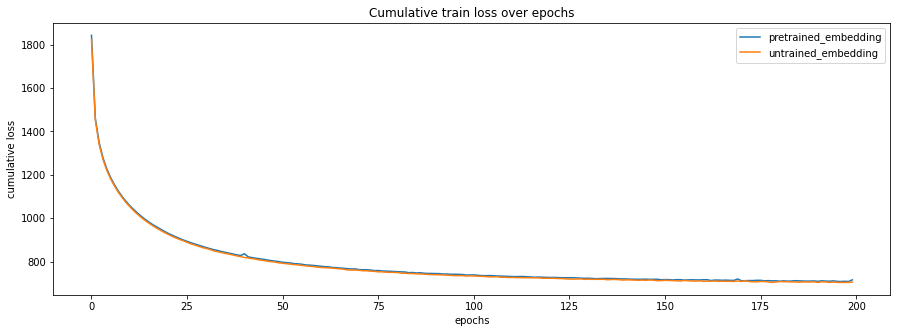

In [18]:
model_names = ["pretrained_embedding", "untrained_embedding"]

plt.figure(figsize=(15,5))
for model_name in model_names:
    log_dict = func_open_log(model_name)
    test_bleu = []
    epochs = []
    train_losses = []
    for i in range(1, len(log_dict)+1):
        test_bleu.append(log_dict[i]["test_bleu"])
        epochs.append(i)
        train_losses.append(log_dict[i]["train_loss"])
    plt.plot(train_losses, label=model_name)
plt.title("Cumulative train loss over epochs")
plt.xlabel("epochs")
plt.ylabel("cumulative loss")
plt.legend()
plt.show()

**Description:** The visualization shows the training loss for the two models: `pretrained_embedding` and `untrained_embedding`. We see that both models optimize the loss function in a smooth learning path, and there is apparently no difference in the development of the training loss between the two models over all epochs despite my expectations.

### Visualizing the average BLEU of 128 randomized samples in the test set

In addition, 128 images were drawn from the test data set after each training epoch. A caption was then created for these and compared with the five correct captions using the BLEU score. For this reason, the average BLEU score of the two model variants (with and without pretrained embedding) per epoch are shown below. For the calculation of the BLEU score a n-gramm range of 1 to 4 was used.

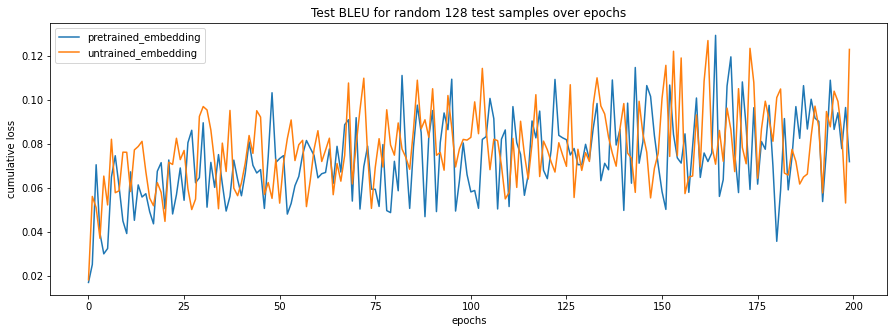

In [19]:
plt.figure(figsize=(15,5))
for model_name in model_names:
    log_dict = func_open_log(model_name)
    test_bleu = []
    epochs = []
    train_losses = []
    for i in range(1, len(log_dict)+1):
        test_bleu.append(log_dict[i]["test_bleu"])
        epochs.append(i)
        train_losses.append(log_dict[i]["train_loss"])
    plt.plot(test_bleu, label=model_name)
plt.title("Test BLEU for random 128 test samples over epochs")
plt.xlabel("epochs")
plt.ylabel("cumulative loss")
plt.legend()
plt.show()

**Description:** When looking at the average BLEU scores of the two models, we see that the average value varies greatly during the various epochs for both model variants. Since the drawn samples represent only a small part of the total test data set, the variation indicates that there are larger differences in the correctness of the caption and the value is therefore still strongly dependent on the drawn captions. Here, in a later run, the number of drawn samples could be increased to obtain a more stable development.
Overall, we see that the BLEU score increases relatively strongly, especially at the beginning, as the training loss decreases. In general, I also can't see any difference between the trained and untrained embedding. 

**Comment:** Since both models seem to perform relatively itentically, it does not make sense for me to analyze both models in more detail. The further analysis therefore focuses on the evaluation of the model with the untrained embeddings. 

In [20]:
model_path = "./saved_models/"
model_name = "untrained_embedding"
epochs_trained = 200

def eval_caption(model, filename=None):
    (file, image, caption) = caption_image(model, filename=filename)

    caption.split()[1:-1]
    train_captions = df_caption.loc[df_caption["filename"]==file]["text"].apply(str.split).to_list()

    bleu =  sentence_bleu(train_captions, caption.split()[1:-1], weights=(1/2, 1/2))
    return file, bleu

model = torch.load(model_path + "{}_e{}.pt".format(model_name, epochs_trained), map_location=device)
df_bleu_scores = pd.DataFrame(columns=["filename", "bleu_score", "set"])

for f in tqdm(set(df_test["filename"])):
    (file, bleu) = (eval_caption(model, filename=f))
    df_bleu_scores.loc[len(df_bleu_scores.index)] = [file, bleu, "test"]

for f in tqdm(set(df_train["filename"])):
    (file, bleu) = (eval_caption(model, filename=f))
    df_bleu_scores.loc[len(df_bleu_scores.index)] = [file, bleu, "train"]


100%|██████████| 6472/6472 [07:09<00:00, 15.08it/s]


### Comparison of bleu scores for train and test set
Below, the distributions of the BLEU scores from the training and test set are analyzed. As a small addaption to the previous calculaton of the BLEU score here, the n-gram range was limited to 2. Therefore the average bleu Score appears to be higher as in the timeseries before.

In [21]:
def plot_bleu_distribution(scores, title):
    '''Creates a histogramm of the bleu scores'''
    plt.figure(figsize=(10, 5))
    plt.hist(scores, bins=25)
    plt.title(title)
    plt.xlabel("BLEU score")
    plt.ylabel("nr of samples")
    plt.show()

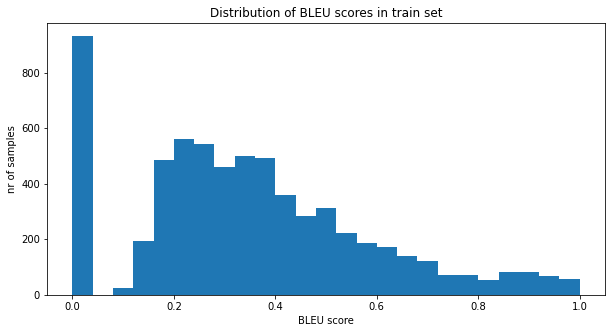

BLEU scores quantiles for train set:
 0.00    0.000
0.25    0.197
0.50    0.323
0.75    0.480
1.00    1.000
Name: bleu_score, dtype: float64


In [22]:
plot_bleu_distribution(df_bleu_scores.loc[df_bleu_scores["set"]=="train"]["bleu_score"], title = "Distribution of BLEU scores in train set" )
print("BLEU scores quantiles for train set:\n", df_bleu_scores.loc[df_bleu_scores["set"]=="train"]["bleu_score"].quantile([0,.25,.5,.75,1]).round(3))

**Description:**  The histogram shows the distribution of the achieved BLEU score scale for all samples from the training set. We see that the BLEU scores are distributed over the entire value scale with a concentration around 0.32. There are several captions with very good BLEU scores greater than 0.8. Also there are many samples which have achieved a BLEU score of 0. Subsequently, we now want to make a comparison of the BLEU scores for the test set.

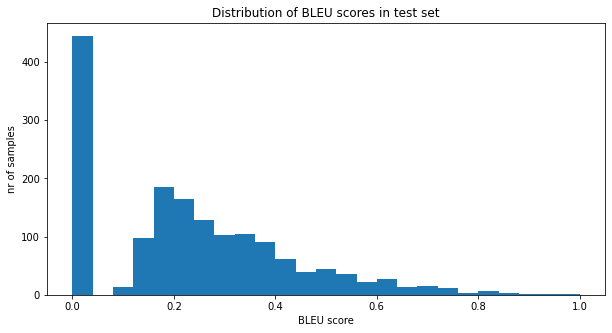

BLEU scores quantiles for test set:
 0.00    0.000
0.25    0.000
0.50    0.214
0.75    0.348
1.00    1.000
Name: bleu_score, dtype: float64


In [23]:
plot_bleu_distribution(df_bleu_scores.loc[df_bleu_scores["set"]=="test"]["bleu_score"], title = "Distribution of BLEU scores in test set" )
print("BLEU scores quantiles for test set:\n", df_bleu_scores.loc[df_bleu_scores["set"]=="test"]["bleu_score"].quantile([0,.25,.5,.75,1]).round(3))

**Description:**  The histogram shows the distribution of the achieved BLEU score scale for all samples from the test set. We see that there are significantly more images in the dataset that received a BLEU score of 0. Also, there are very few images in the value range 0.6 upwards. This might be because of several reasons. On the one hand, a minimal deterioration of the average BLEU score can be expected due to variance in sentence structures. Furthermore, the test set contains words and objects that were not used in the training. Thus, the model is sometimes not able to recognize these objects at all. 

### Visualizing single examples

Now we will take a closer look at a handful of examples with very good and very bad BLEU Scores from the test set.

In [24]:
df_bleu_scores_test = df_bleu_scores.loc[df_bleu_scores["set"]=="test"]
df_bleu_scores_test = df_bleu_scores_test.sort_values("bleu_score", ascending=False).reset_index(drop=True)

def sample_presentation(model, filename):
    '''Shows an Image with corresponging caption, bleu score and ranking compared to the other samples in the test set'''
    (file, image, caption) = caption_image(model, filename = filename)
    plt.imshow(image)
    plt.show()
    print("Captioning image: {}".format(file))  
    print("Caption sencence:", caption)
    caption.split()[1:-1]
    train_captions = df_caption.loc[df_caption["filename"]==file]["text"].apply(str.split).to_list()
    bleu =  sentence_bleu(train_captions, caption.split()[1:-1], weights=(1/2, 1/2))
    print("BLEU score:",bleu)
    print("Ranking in test set according to BLEU score:", 1+int(df_bleu_scores_test.loc[df_bleu_scores_test["filename"] == file].index.values), "of", len(df_bleu_scores_test))

#### Top captions

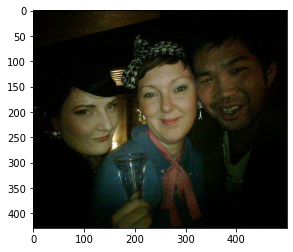

Captioning image: 3134387321_3a253224c1.jpg
Caption sencence: <bos> three people pose for a picture . <eos> 
BLEU score: 1.0
Ranking in test set according to BLEU score: 1 of 1619


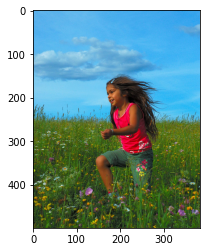

Captioning image: 174466741_329a52b2fe.jpg
Caption sencence: <bos> a girl in a pink shirt is running through a field . <eos> 
BLEU score: 0.9534625892455924
Ranking in test set according to BLEU score: 2 of 1619


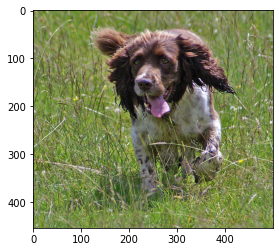

Captioning image: 747242766_afdc9cb2ba.jpg
Caption sencence: <bos> a dog runs through the grass . <eos> 
BLEU score: 0.9128709291752769
Ranking in test set according to BLEU score: 4 of 1619


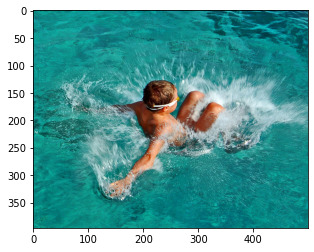

Captioning image: 2760371526_63f3d01760.jpg
Caption sencence: <bos> a boy in a swimming pool . <eos> 
BLEU score: 0.9128709291752769
Ranking in test set according to BLEU score: 3 of 1619


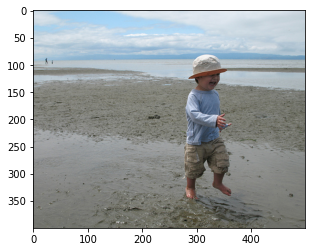

Captioning image: 3623331945_df0f51d7dd.jpg
Caption sencence: <bos> a boy in a blue shirt is running through the sand . <eos> 
BLEU score: 0.8528028654224418
Ranking in test set according to BLEU score: 6 of 1619


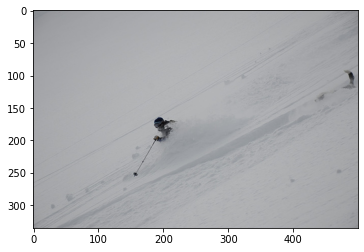

Captioning image: 3173014908_b3e69594b6.jpg
Caption sencence: <bos> a skier is skiing down a snowy hill . <eos> 
BLEU score: 0.816496580927726
Ranking in test set according to BLEU score: 11 of 1619


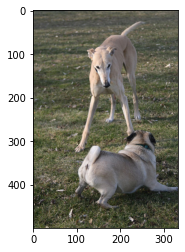

Captioning image: 3375134059_7e9eb2ef01.jpg
Caption sencence: <bos> two dogs play with each other in the grass . <eos> 
BLEU score: 0.816496580927726
Ranking in test set according to BLEU score: 10 of 1619


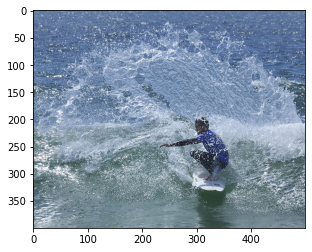

Captioning image: 3431261634_c73360406a.jpg
Caption sencence: <bos> a surfer is riding a wave . <eos> 
BLEU score: 0.7559289460184544
Ranking in test set according to BLEU score: 18 of 1619


In [25]:
files = [
    "3134387321_3a253224c1.jpg", "174466741_329a52b2fe.jpg", "747242766_afdc9cb2ba.jpg", "2760371526_63f3d01760.jpg", 
    "3623331945_df0f51d7dd.jpg", "3173014908_b3e69594b6.jpg", "3375134059_7e9eb2ef01.jpg", "3431261634_c73360406a.jpg"]
for file in files:
    sample_presentation(model, file)

**Description:** We see here some examples with some of the BLEU scores from the test set. The generated captions for the images with the best BLEU Scores are very good in my opinion and the I think the high scores for these examples are justified. However, it seems at first glance that the generated captions are rather shorter than the average of the captions used in the training, but this thesis would have to be evaluated separately.

#### Flop captions

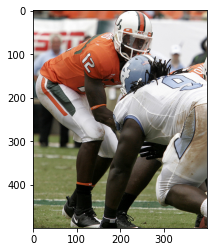

Captioning image: 2896668718_0c3cff910f.jpg
Caption sencence: <bos> two uniformed american flags <eos> 
BLEU score: 0
Ranking in test set according to BLEU score: 1619 of 1619


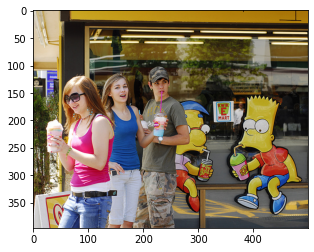

Captioning image: 782401952_5bc5d3413a.jpg
Caption sencence: <bos> four women perform together . <eos> 
BLEU score: 3.6610910047675874e-155
Ranking in test set according to BLEU score: 1618 of 1619


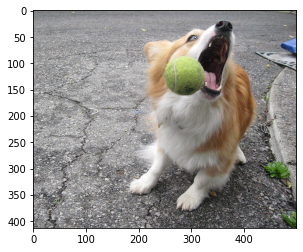

Captioning image: 3081734118_6f2090215c.jpg
Caption sencence: <bos> a puppy runs through the grass . <eos> 
BLEU score: 3.903263309996421e-155
Ranking in test set according to BLEU score: 1617 of 1619


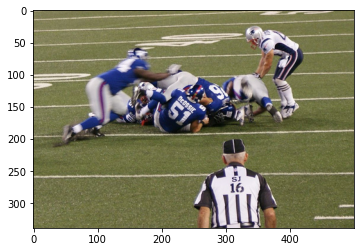

Captioning image: 2921430836_3b4d062238.jpg
Caption sencence: <bos> two men playing soccer . <eos> 
BLEU score: 4.239031324788977e-155
Ranking in test set according to BLEU score: 1615 of 1619


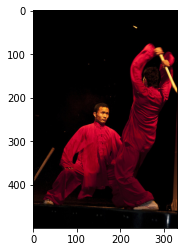

Captioning image: 3226541300_6c81711e8e.jpg
Caption sencence: <bos> a young girl wearing a pink hat is standing by the water <eos> 
BLEU score: 4.306075028866568e-155
Ranking in test set according to BLEU score: 1614 of 1619


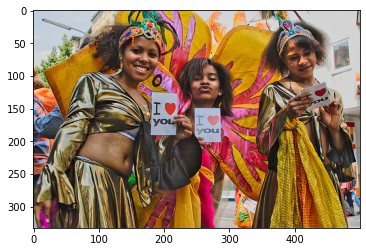

Captioning image: 3587449716_3bf1552c36.jpg
Caption sencence: <bos> a group of people gather around a blue <unk> bed . <eos> 
BLEU score: 4.497548684366688e-155
Ranking in test set according to BLEU score: 1611 of 1619


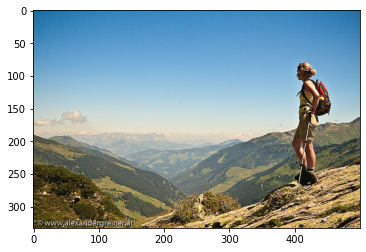

Captioning image: 2925242998_9e0db9b4a2.jpg
Caption sencence: <bos> a girl is rock climbing . <eos> 
BLEU score: 5.415362874261817e-155
Ranking in test set according to BLEU score: 1603 of 1619


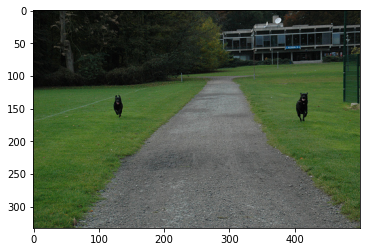

Captioning image: 295258727_eaf75e0887.jpg
Caption sencence: <bos> a dog runs through the woods . <eos> 
BLEU score: 5.514619442930451e-155
Ranking in test set according to BLEU score: 1599 of 1619


In [26]:
files = ["2896668718_0c3cff910f.jpg", "782401952_5bc5d3413a.jpg", "3081734118_6f2090215c.jpg", "2921430836_3b4d062238.jpg", 
         "3226541300_6c81711e8e.jpg", "3587449716_3bf1552c36.jpg", "2925242998_9e0db9b4a2.jpg", "295258727_eaf75e0887.jpg"]
for file in files:
    sample_presentation(model, file)

**Description:**  At the other end, we see significantly worse performance. There are some images where the model is completely off like in image `3226541300_6c81711e8e.jpg` or `782401952_5bc5d3413a.jpg`. But there are also other images with a BLEU score around 0, which have at least partially reasonable generated captions. For example, in image `2925242998_9e0db9b4a2.jpg` we see a young woman hiking instead of rock climbing and in image `295258727_eaf75e0887.jpg` we see two dogs running over the grass with a forest in the background which is why the model might have interpretet them as running trough the woods.


## Conclusion

Overall, I feel good about the result i was able to achieve. The quality of the captions varied from quite decent to completely off target. I think the model is able to recognize single or multiple objects relatively well, since the resnet18 was also pre-trained for this task. However, I have the impression that the LSTM can not always correctly put the individual objects in relation to each other and mostly just learns a general sentence structure based on memorized patterns. In this context, it would not surprise me if the model could not generate a correct sentence structure for a previously unseen interavtions between known objects. Also, the model generally performs better with objects and scenes that occur frequently in the training dataset. I would therefore argue that the model would be able to increase the quality of the predictions if more similar examples were present in the training data set for the bad captions.
